# A MODEL FOR OPTIMIZING DIAGNOSIS AND CLASSIFICATION OF LUNG CANCER USING DEEP LEARNING TECHNIQUES (CNN)

    *************************************************************
    Author:  
    Program: 
    Course:  AI: Machine Learning
    Date:    
    Version: 1.3
    E-mail:  
    *************************************************************
    

In [ ]:
# importing libraries and packages

In [2]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
%matplotlib inline

import imageio.v2 as imageio

import os, shutil
from os import listdir, path

#tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras import layers

# CNN keras libs
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf

from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

# Visualizing Model Architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.applications.resnet import ResNet50
from keras.utils import plot_model
from keras.utils import load_img, img_to_array, array_to_img
import pydot
import cv2

# loading saved cnn model
from keras.models import load_model
from keras.preprocessing import image
import keras.utils as image

# Evaluation Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, roc_auc_score

In [3]:
from sklearn.metrics import classification_report

In [4]:
# Avoid OOM errors by setting memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Connecting Google Colab to Google Drive
#from google.colab import drive
#drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Creating Training Set

In [5]:
directory = r'input/IQO_lung_cancer_dataset/datasets/train_set'

categories = ['Bengin_cases', 'Malignant_cases', 'Normal_cases']

### Image Size Variations

In [6]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

{'Bengin_cases': {'64 x 64': 396, '512 x 512': 84},
 'Malignant_cases': {'64 x 64': 860,
  '512 x 512': 332,
  '404 x 511': 1,
  '512 x 801': 28,
  '512 x 623': 31},
 'Normal_cases': {'64 x 64': 860, '512 x 512': 291}}

# Image Preprocessing and Testing

Bengin_cases


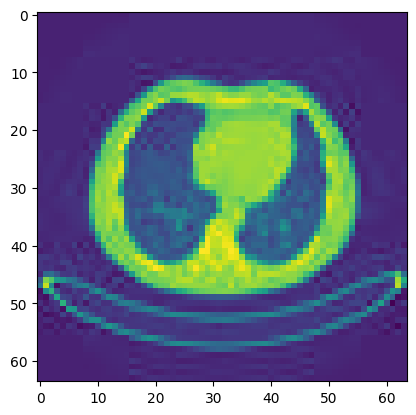

Malignant_cases


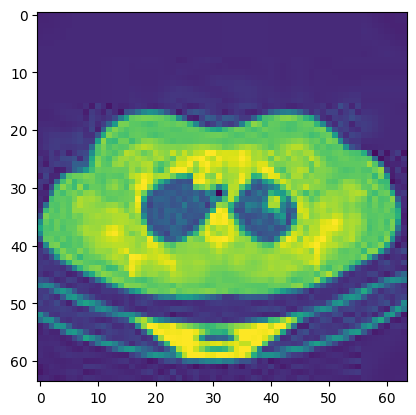

Normal_cases


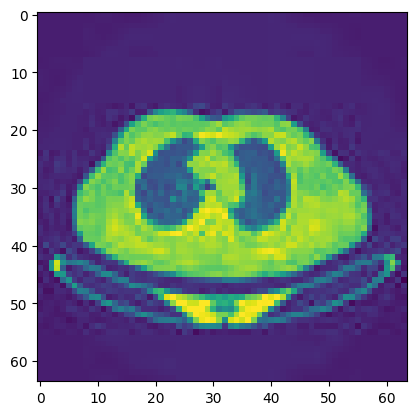

In [7]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

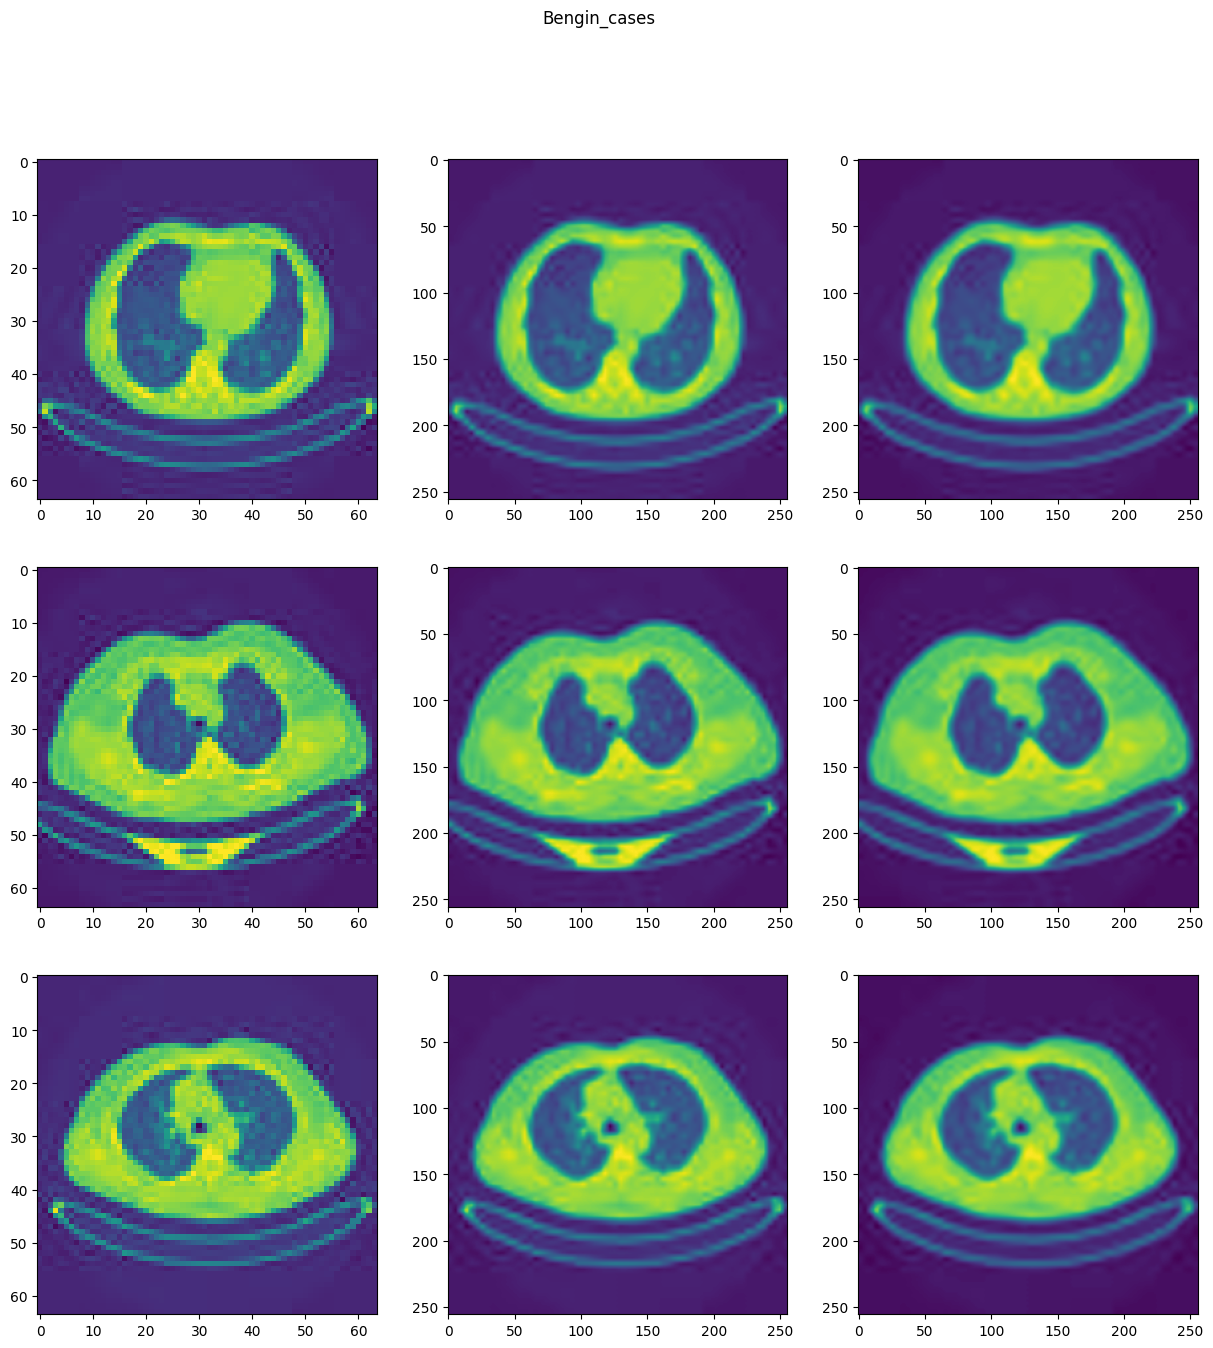

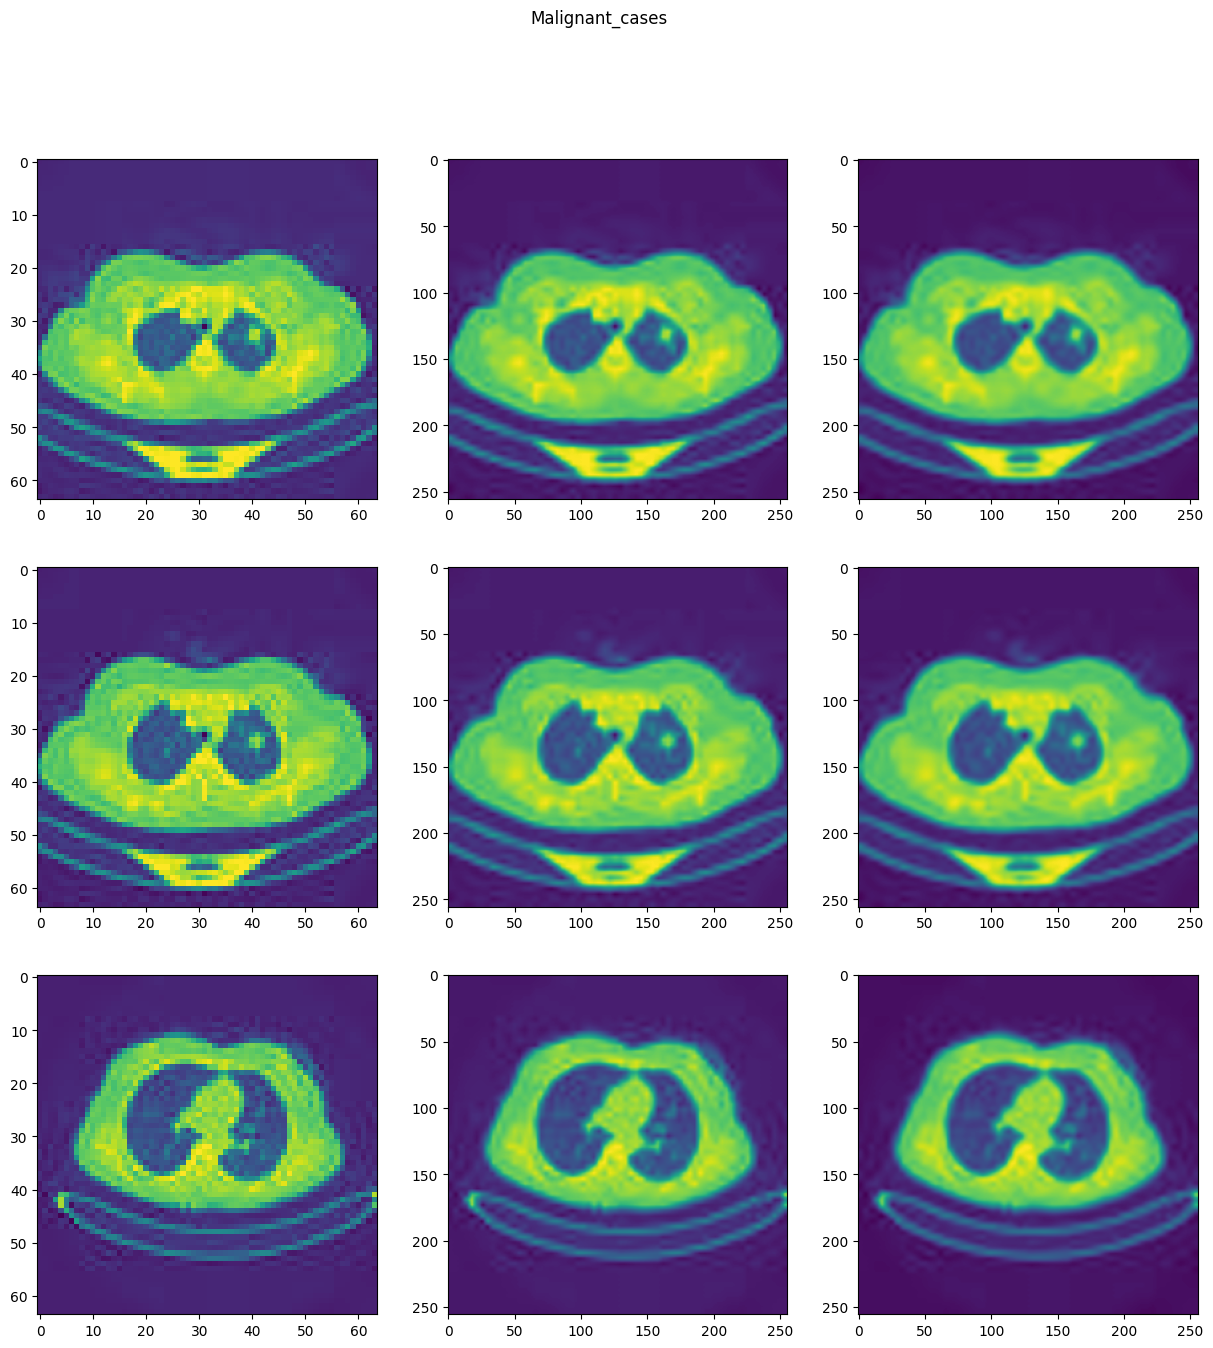

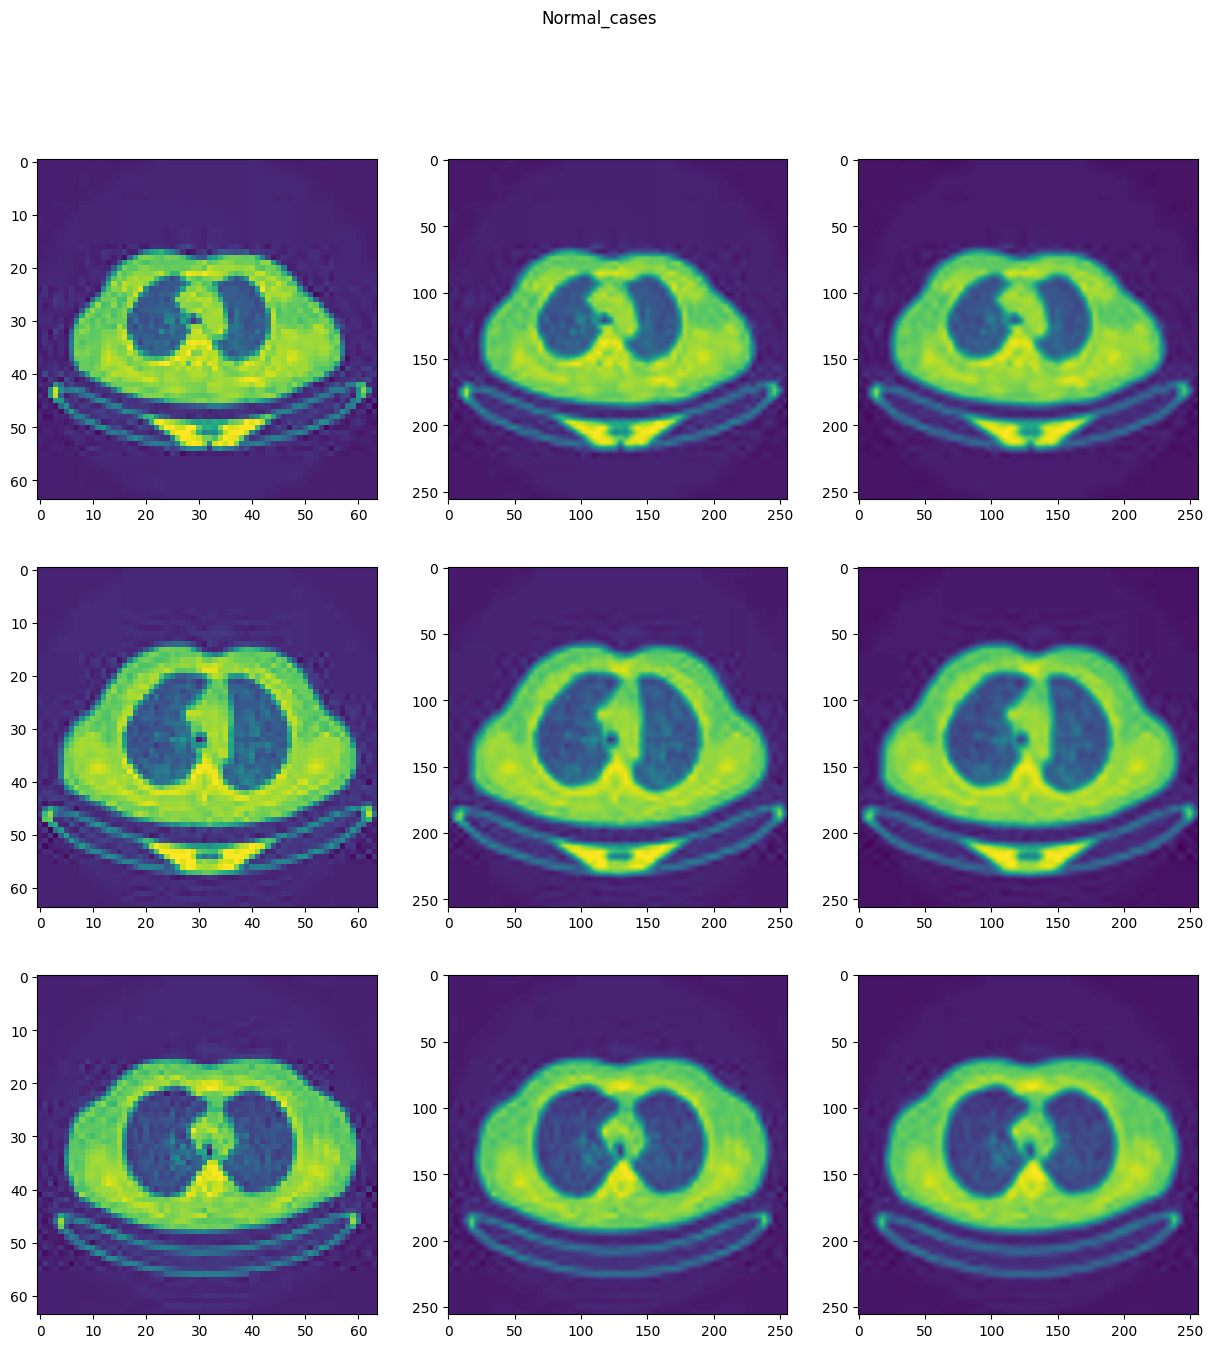

In [47]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

In [8]:
# Setting Dataset Home Path on google drive

# NOTE:
# Change these two paths to point to where you saved the Dataset on your google drive
# Click the link that pops-up to authenticate with your google account to allow colab access your drive
# Copy the access code generated and past in the space provided in your google colab and press enter.
# Everything in the codes should now run fine
# I have shared the Dataset folder on my google drive with you.
#/content/gdrive/My Drive/Datasets/LungCancerDataset/datasets

origin_path = "input/IQO_lung_cancer_dataset/datasets"
model_path = "input/IQO_lung_cancer/models"
architecture_path = "input/IQO_lung_cancer/architectures"

## Viewing Filenames and Labels

<p>Training Set</p>

In [9]:
def view_files_and_labels_train(folder="train_set"):
  # Initialize
  imageNames = list()
  labels = list()

  # Paths
  normal_path = "input/IQO_lung_cancer_dataset/datasets/train_set/Normal_cases/"
  bengin_cases_path = "input/IQO_lung_cancer_dataset/datasets/train_set/Bengin_cases/"
  malignant_cases_path = "input/IQO_lung_cancer_dataset/datasets/train_set/Malignant_cases/"

  # Get data and label
  for file in listdir(normal_path):
    imageNames.append(file)
    labels.append('normal')

  for file in listdir(bengin_cases_path):
    imageNames.append(file)
    labels.append('bengin_cases_cancer')

  for file in listdir(malignant_cases_path):
    imageNames.append(file)
    labels.append('malignant_cases_cancer')

  # Creating a dictionary of dataset
  dico = {'filename':imageNames, 'label':labels}

  # Converting dico to df
  df = pd.DataFrame(data=dico)

  return df

<p>Validation set<p>

In [10]:
def view_files_and_labels_valid(folder="validation_set"):
  # Initialize
  imageNames = list()
  labels = list()

  # Paths
  normal_path = "input/IQO_lung_cancer_dataset/datasets/validation_set/Normal_cases/"
  bengin_cases_path = "input/IQO_lung_cancer_dataset/datasets/validation_set/Bengin_cases/"
  malignant_cases_path = "input/IQO_lung_cancer_dataset/datasets/validation_set/Malignant_cases/"

  # Get data and label
  for file in listdir(normal_path):
    imageNames.append(file)
    labels.append('normal')

  for file in listdir(bengin_cases_path):
    imageNames.append(file)
    labels.append('bengin_cases_cancer')

  for file in listdir(malignant_cases_path):
    imageNames.append(file)
    labels.append('malignant_cases_cancer')

  # Creating a dictionary of dataset
  dico = {'filename':imageNames, 'label':labels}

  # Converting dico to df
  df = pd.DataFrame(data=dico)

  return df

<p>Testing set</p>

In [11]:
def view_files_and_labels_test(folder="test"):
  # Initialize
  imageNames = list()
  labels = list()

  # Paths
  normal_path = "input/IQO_lung_cancer_dataset/datasets/test_set/Normal_cases/"
  bengin_cases_path = "input/IQO_lung_cancer_dataset/datasets/test_set/Bengin_cases/"
  malignant_cases_path = "input/IQO_lung_cancer_dataset/datasets/test_set/Malignant_cases/"

  # Get data and label
  for file in listdir(normal_path):
    imageNames.append(file)
    labels.append('normal')

  for file in listdir(bengin_cases_path):
    imageNames.append(file)
    labels.append('bengin_cases_cancer')

  for file in listdir(malignant_cases_path):
    imageNames.append(file)
    labels.append('malignant_cases_cancer')

  # Creating a dictionary of dataset
  dico = {'filename':imageNames, 'label':labels}

  # Converting dico to df
  df = pd.DataFrame(data=dico)

  return df

In [12]:
# Training, validation and test Sets summary
df_train = view_files_and_labels_train(folder="train_set")
df_valid = view_files_and_labels_valid(folder="validation_set")
df_test = view_files_and_labels_test(folder="test_set")

In [13]:
print("Training Set")
print("------------")
print(f"{df_train.label.value_counts()} \n")

print("Validation Set")
print("--------------")
print(f"{df_valid.label.value_counts()} \n")

print("Testing Set")
print("------------")
print(f"{df_test.label.value_counts()}")

Training Set
------------
label
malignant_cases_cancer    1252
normal                    1151
bengin_cases_cancer        480
Name: count, dtype: int64 

Validation Set
--------------
label
malignant_cases_cancer    357
normal                    328
bengin_cases_cancer       137
Name: count, dtype: int64 

Testing Set
------------
label
malignant_cases_cancer    178
normal                    163
bengin_cases_cancer        55
Name: count, dtype: int64


Graphical label implementation

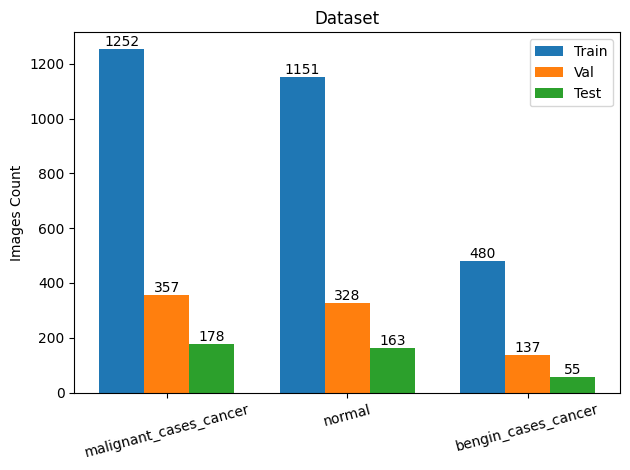

In [212]:
labels = ['malignant_cases_cancer', 'normal', 'bengin_cases_cancer']
train_list = df_train.label.value_counts()
val_list = df_valid.label.value_counts()
test_list = df_test.label.value_counts()

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

In [56]:
df_train.head(2)

,filename,label
0,1 (1).jpg,normal
1,1 (10).jpg,normal


In [57]:
df_valid.tail(2)

,filename,label
820,Malignant case (503).jpg,malignant_cases_cancer
821,Malignant case (504).jpg,malignant_cases_cancer


In [58]:
df_test.tail(2)

,filename,label
394,Malignant case (559).jpg,malignant_cases_cancer
395,Malignant case (560).jpg,malignant_cases_cancer


# ==================================================
# CNN CODES BEGINS FROM HERE
# ==================================================

In [17]:
# del cnn_model1
# del cnn_model2

# Model Configuration 1.1

using VGG-16 MODEL

In [31]:
# using VGG16
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(128,128,3)
)

In [33]:
NUM_CLASSES = 4

vgg_model = Sequential()
vgg_model.add(base_model)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dropout(0.25))
vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg_model.layers[0].trainable = False

vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

vgg_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_5 (Dropout)         (None, 8192)              0         
                                                                 
 dense_5 (Dense)             (None, 4)                 32772     
                                                                 
Total params: 14,747,460
Trainable params: 32,772
Non-trainable params: 14,714,688
_________________________________________________________________


## Model Configuration 1

In [117]:
# Initializing the CNN
cnn_model1 = Sequential()

# Adding the Convolution Layers
cnn_model1.add(Conv2D(filters=64, kernel_size=(5,5),
                          input_shape=(512,512,3), activation='relu'))
cnn_model1.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
# Adding the Maxpooling Layer
cnn_model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Adding Convolution Layers
cnn_model1.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
cnn_model1.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
# Adding Maxpooling Layer
cnn_model1.add(MaxPool2D(pool_size=(2,2)))

# Adding Convolution Layers
cnn_model1.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
cnn_model1.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# Adding Maxpooling Layer
cnn_model1.add(MaxPool2D(pool_size=(2,2)))

# # Adding Convolution Layers
# cnn_model1.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# cnn_model1.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# # Adding Maxpooling Layer
# cnn_model1.add(MaxPool2D(pool_size=(2,2)))

# Step 3: Adding the Flatten Layer and then to Fully_connected ANN
cnn_model1.add(Flatten())
cnn_model1.add(Dense(units=512, activation='relu'))
#cnn_model1.add(Dense(units=256, activation='relu'))
cnn_model1.add(Dense(units=128, activation='relu'))
#cnn_model1.add(Dense(units=64, activation='relu'))
cnn_model1.add(Dense(units=32, activation='relu'))
#cnn_model1.add(Dense(units=16, activation='relu'))

cnn_model1.add(Dense(units=3, activation='softmax')) # output layer

# Compiling the model
cnn_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Alternative Configuration for Multi-lable case
# cnn_model1.add(Dense(units=2, activation='sigmoid')) # output layer
# cnn_model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Model Configuration 2

In [121]:
# Architecture [D132 + RELU D232]
cnn_model2 = Sequential()

# Convolution Layers
cnn_model2.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'Same',
                 activation ='relu', input_shape = (256,256,3)))
cnn_model2.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'Same',
                 activation ='relu'))
# Maxpooling Layer
cnn_model2.add(MaxPool2D(pool_size=(2,2)))
#cnn_model2.add(Dropout(0.25)) # Randomly drops a proportion of d ntwk, to improve generalizatn n reduce over-fitting n computatn


# Convolution Layers
cnn_model2.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
cnn_model2.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
# Maxpooling and Dropout Layers
cnn_model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnn_model2.add(Dropout(0.25))


# Convolution Layers
cnn_model2.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
cnn_model2.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
# Maxpooling Layer
cnn_model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
#cnn_model2.add(Dropout(0.25))


# # Convolution Layers
# cnn_model2.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',
#                  activation ='relu'))
# cnn_model2.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',
#                  activation ='relu'))
# # Maxpooling Layer
# cnn_model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# cnn_model2.add(Dropout(0.25))



cnn_model2.add(Flatten()) # Converts nodes into a single 1-D array, to allow fully-connected ANN
cnn_model2.add(Dense(512, activation = "relu")) # 'relu' = max(0, x), to introduce non-linearity
#cnn_model2.add(Dense(256, activation = "relu")) # 'relu' = max(0, x), to introduce non-linearity
#cnn_model2.add(Dropout(0.25))

cnn_model2.add(Dense(128, activation = "relu")) # 'relu' = max(0, x), to introduce non-linearity
#cnn_model2.add(Dense(64, activation = "relu")) # 'relu' = max(0, x), to introduce non-linearity
cnn_model2.add(Dropout(0.25))

cnn_model2.add(Dense(32, activation = "relu")) # 'relu' = max(0, x), to introduce non-linearity
#cnn_model2.add(Dense(16, activation = "relu")) # 'relu' = max(0, x), to introduce non-linearity
#cnn_model2.add(Dropout(0.25))


cnn_model2.add(Dense(3, activation = "softmax")) # 'softmax' a multiclass activation fn, uses prob distr of outputs.
                                            # usually used at the output layer of non-binary classification problems

# Configuring optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) # Root Mean Squared Optimizer with default values
# Note:
      # * Could have used Stochastic Gradient Descent ('sgd') optimizer instead but it is slow, and RMSprop is simple and faster
      # * 'adam' is another optimizer. An improvement of 'sgd' optimizer

# Compile the cnn_model2
cnn_model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Alternative Configuration for Multi-lable case
# cnn_model1\2.add(Dense(units=3, activation='sigmoid')) # output layer
# cnn_model2.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])


C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Model Configuration 3

In [127]:

# Initializing the CNN
cnn_model3 = Sequential()

# Adding the Convolution Layers
cnn_model3.add(Conv2D(filters=64, kernel_size=(5,5),
                          input_shape=(128,128,3), activation='relu'))
cnn_model3.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
# Adding the Maxpooling Layer
cnn_model3.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Adding Convolution Layers
cnn_model3.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
cnn_model3.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
# Adding Maxpooling Layer
cnn_model3.add(MaxPool2D(pool_size=(2,2)))

# Adding Convolution Layers
cnn_model3.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
cnn_model3.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# Adding Maxpooling Layer
cnn_model3.add(MaxPool2D(pool_size=(2,2)))

# # Adding Convolution Layers
# cnn_model1.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# cnn_model1.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# # Adding Maxpooling Layer
# cnn_model1.add(MaxPool2D(pool_size=(2,2)))

# Step 3: Adding the Flatten Layer and then to Fully_connected ANN
cnn_model3.add(Flatten())
cnn_model3.add(Dense(units=512, activation='relu'))
#cnn_model3.add(Dense(units=256, activation='relu'))
cnn_model3.add(Dense(units=128, activation='relu'))
#cnn_model3.add(Dense(units=64, activation='relu'))
cnn_model3.add(Dense(units=32, activation='relu'))
#cnn_model3.add(Dense(units=16, activation='relu'))

cnn_model3.add(Dense(units=3, activation='softmax')) # output layer

# Compiling the model
cnn_model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Alternative Configuration for Multi-lable case
# cnn_model3.add(Dense(units=2, activation='sigmoid')) # output layer
# cnn_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Configuration 4

In [27]:
#del cnn_model4

In [96]:
# Initializing the CNN
cnn_model4 = Sequential()

# Adding the Convolution Layers
cnn_model4.add(Conv2D(filters=64, kernel_size=(5,5),
                          input_shape=(64,64,3), activation='relu'))
cnn_model4.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
# Adding the Maxpooling Layer
cnn_model4.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Adding Convolution Layers
cnn_model4.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
cnn_model4.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
# Adding Maxpooling Layer
cnn_model4.add(MaxPool2D(pool_size=(2,2)))

# Adding Convolution Layers
cnn_model4.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
cnn_model4.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# Adding Maxpooling Layer
cnn_model4.add(MaxPool2D(pool_size=(2,2)))

# # Adding Convolution Layers
# cnn_model4.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# cnn_model4.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
# # Adding Maxpooling Layer
# cnn_model4.add(MaxPool2D(pool_size=(2,2)))

# Step 3: Adding the Flatten Layer and then to Fully_connected ANN
cnn_model4.add(Flatten())
cnn_model4.add(Dense(units=512, activation='relu'))
#cnn_model4.add(Dense(units=256, activation='relu'))
cnn_model4.add(Dense(units=128, activation='relu'))
#cnn_model4.add(Dense(units=64, activation='relu'))
cnn_model4.add(Dense(units=32, activation='relu'))
#cnn_model4.add(Dense(units=16, activation='relu'))

cnn_model4.add(Dense(units=3, activation='softmax')) # output layer

# Compiling the model
cnn_model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Alternative Configuration for Multi-lable case
# cnn_model4.add(Dense(units=2, activation='sigmoid')) # output layer
# cnn_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Architectures

## Architecture for Model1 with Configuration 1 (adam optim @512x512x3 Input)

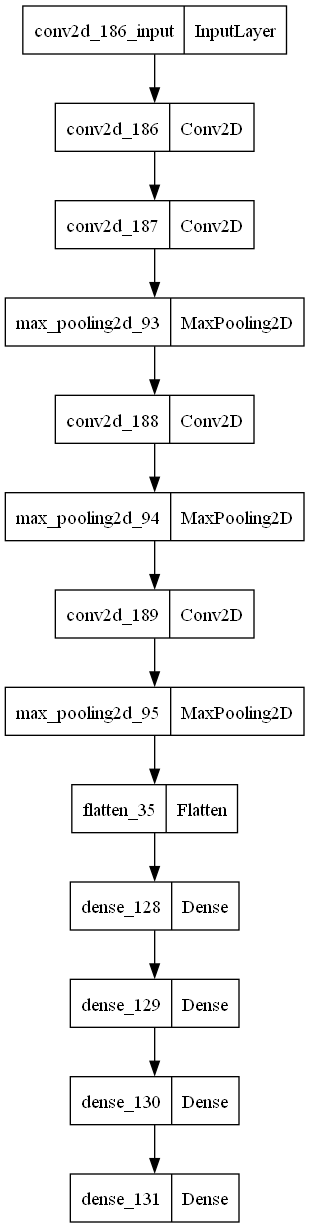

In [118]:
# Visualizing the Architecture: Method 1
# SVG(data=model_to_dot(cnn_model1).create(prog='dot', format='svg'))

# Visualizing and Saving architecture to file using pydot: Method 2 (Better)
plot_model(model=cnn_model1, to_file=architecture_path + '/lung_cancer_model_config1_adam_Architecture_1st.png')

In [123]:
# Summary
cnn_model1.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_186 (Conv2D)         (None, 252, 252, 64)      4864      
                                                                 
 conv2d_187 (Conv2D)         (None, 248, 248, 64)      102464    
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 124, 124, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_188 (Conv2D)         (None, 120, 120, 128)     204928    
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 60, 60, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_189 (Conv2D)         (None, 58, 58, 256)     

## Architecture for Model2 with Configuration 2 (RMSprop optim @256x256x3 input)

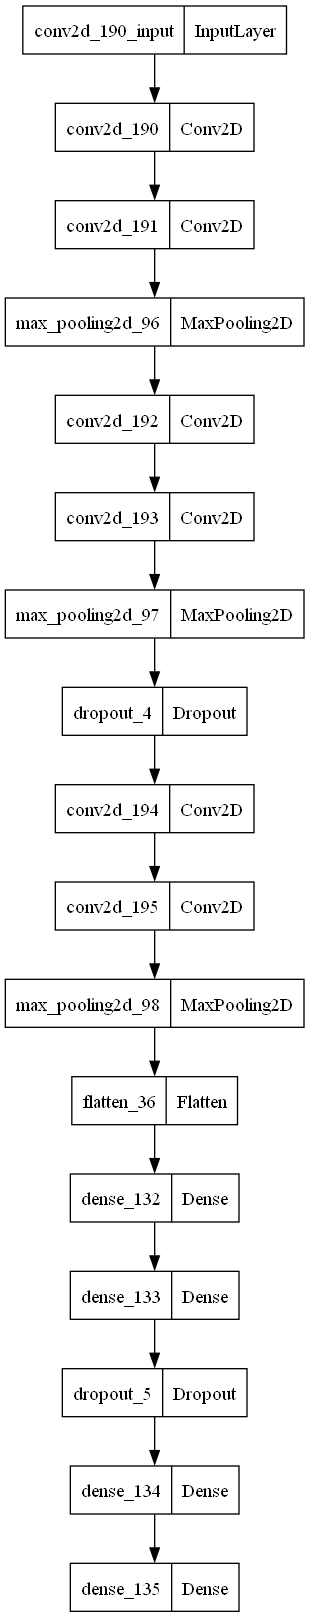

In [124]:
# Visualizing the Architecture: Method 1
#SVG(data=model_to_dot(cnn_model2).create(prog='dot', format='svg'))

# Saving the above image to file using pydot: Method 2 (Better)
plot_model(model=cnn_model2, to_file=architecture_path + '/lung_cancer_model_config2_RMSprop_Architecture_1st.png')

In [125]:
# Summary
cnn_model2.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_190 (Conv2D)         (None, 256, 256, 64)      4864      
                                                                 
 conv2d_191 (Conv2D)         (None, 256, 256, 64)      102464    
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_192 (Conv2D)         (None, 128, 128, 128)     204928    
                                                                 
 conv2d_193 (Conv2D)         (None, 128, 128, 128)     409728    
                                                                 
 max_pooling2d_97 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                

# Architecture for Model 3 configuration 3 (with Adams @128x128x3 input)

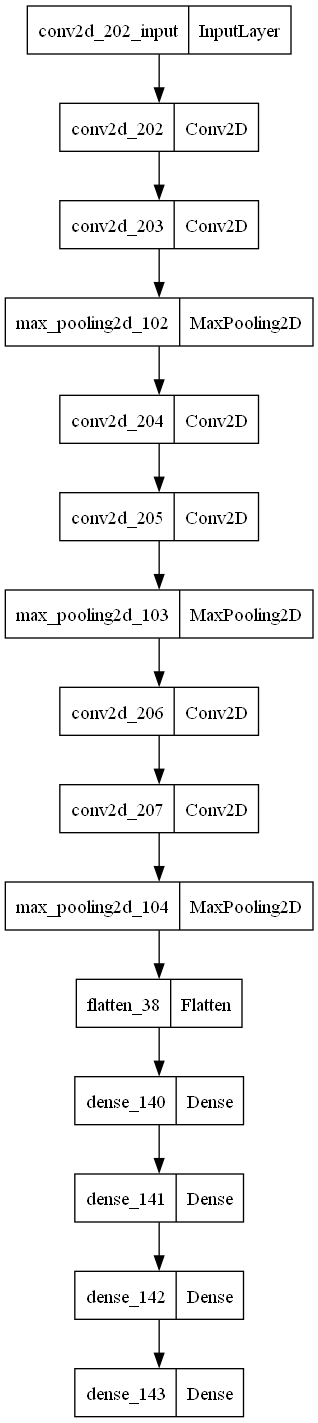

In [128]:

plot_model(model=cnn_model3, to_file=architecture_path + '/lung_cancer_model_config3_adam_Architecture_1st.png')

In [129]:
# Summary
cnn_model3.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_202 (Conv2D)         (None, 124, 124, 64)      4864      
                                                                 
 conv2d_203 (Conv2D)         (None, 120, 120, 64)      102464    
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 60, 60, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_204 (Conv2D)         (None, 56, 56, 128)       204928    
                                                                 
 conv2d_205 (Conv2D)         (None, 52, 52, 128)       409728    
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 26, 26, 128)      0         
 ng2D)                                               

# Architecture for Model 4 COnfiguration 4 (Adam @64x64x3 input)

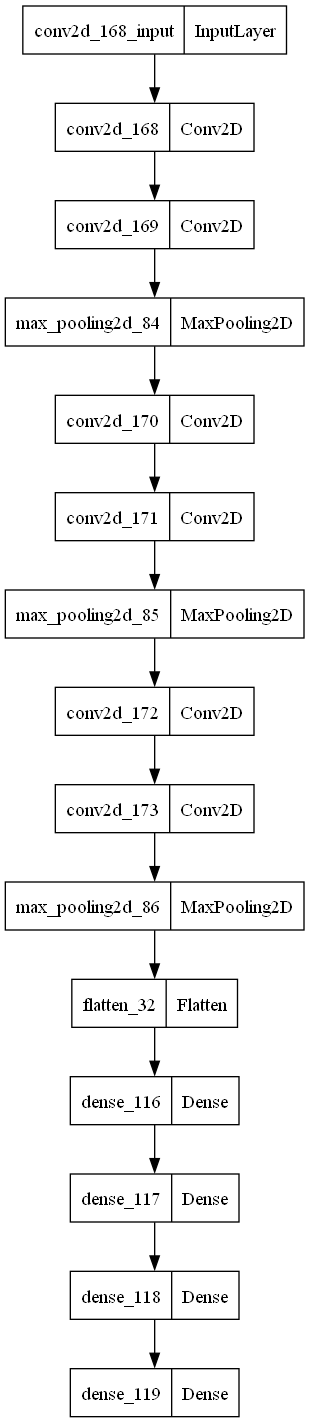

In [132]:

plot_model(model=cnn_model4, to_file=architecture_path + '/lung_cancer_model_config4_Adam_Architecture_1st.png')

In [130]:
# Summary

cnn_model4.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_168 (Conv2D)         (None, 60, 60, 64)        4864      
                                                                 
 conv2d_169 (Conv2D)         (None, 56, 56, 64)        102464    
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_170 (Conv2D)         (None, 24, 24, 128)       204928    
                                                                 
 conv2d_171 (Conv2D)         (None, 20, 20, 128)       409728    
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 10, 10, 128)      0         
 g2D)                                                

# Image Preprocessing - Augmentation (Generation)

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,  # randomly flip images
                                   featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                   samplewise_std_normalization=False,  # divide each input by its std
                                   zca_whitening=False,  # apply ZCA whitening
                                   rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                                   width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                   )


validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
for file in listdir(origin_path + '/train_set'):
    print(file)

Bengin_cases
Malignant_cases
Normal_cases


In [27]:
# Generating the training and test data sets
# NOTE: 'target_size' should match the 'input_shape' of the convolution layer


training_set_aug_images = train_datagen.flow_from_directory(
                                            origin_path + '/train_set',
                                            target_size=(256,256),
                                            batch_size=32,
                                            class_mode='categorical')

validation_set_aug_images = validation_datagen.flow_from_directory(
                                            origin_path + '/validation_set',
                                            target_size=(256,256),
                                            batch_size=32,
                                            class_mode='categorical')

testing_set_aug_images = test_datagen.flow_from_directory(
                                            origin_path + '/test_set',
                                            target_size=(256,256),
                                            batch_size=32,
                                            class_mode='categorical')


Found 2883 images belonging to 3 classes.
Found 822 images belonging to 3 classes.
Found 396 images belonging to 3 classes.


In [28]:
total_Samples = len(training_set_aug_images.labels) + len(validation_set_aug_images.labels) + len(testing_set_aug_images.labels)
perc_train = np.round((len(training_set_aug_images.labels) / total_Samples) * 100)
perc_valid = np.round((len(validation_set_aug_images.labels) / total_Samples) * 100)
perc_test = np.round((len(testing_set_aug_images.labels) / total_Samples) * 100)

print(f'Total Training Sample: {len(training_set_aug_images.labels)}, \t Percentage: {perc_train}%')
print(f'Total Validation Sample: {len(validation_set_aug_images.labels)}, \t Percentage: {perc_valid}%')
print(f'Total Testing Sample: {len(testing_set_aug_images.labels)}, \t Percentage: {perc_test}%')

Total Training Sample: 2883, 	 Percentage: 70.0%
Total Validation Sample: 822, 	 Percentage: 20.0%
Total Testing Sample: 396, 	 Percentage: 10.0%


# Data Augmentations for Model 3 and Model 4

In [35]:
training_set_aug_images_conf3 = train_datagen.flow_from_directory(
                                            origin_path + '/train_set',
                                            target_size=(128,128),
                                            batch_size=32,
                                            class_mode='categorical')

validation_set_aug_images_conf3 = validation_datagen.flow_from_directory(
                                            origin_path + '/validation_set',
                                            target_size=(128,128),
                                            batch_size=32,
                                            class_mode='categorical')

testing_set_aug_images_conf3 = test_datagen.flow_from_directory(
                                            origin_path + '/test_set',
                                            target_size=(128,128),
                                            batch_size=32,
                                            class_mode='categorical')

Found 2883 images belonging to 3 classes.


Found 822 images belonging to 3 classes.
Found 396 images belonging to 3 classes.


In [23]:
training_set_aug_images_conf4 = train_datagen.flow_from_directory(
                                            origin_path + '/train_set',
                                            target_size=(64,64),
                                            batch_size=32,
                                            class_mode='categorical')

validation_set_aug_images_conf4 = validation_datagen.flow_from_directory(
                                            origin_path + '/validation_set',
                                            target_size=(64,64),
                                            batch_size=32,
                                            class_mode='categorical')

testing_set_aug_images_conf4 = test_datagen.flow_from_directory(
                                            origin_path + '/test_set',
                                            target_size=(64,64),
                                            batch_size=32,
                                            class_mode='categorical')

Found 2883 images belonging to 3 classes.
Found 822 images belonging to 3 classes.


Found 396 images belonging to 3 classes.


# Training the Models

## Note:
* I used a small size of epochs (5) because i used a CPU and this actually took up to 6 hours
* For improved predictive accuracy, the number of epochs should be set to around (100 to 150) so the model can learn more
* Use a GPU System</b> <br />


<b>ReduceLROnPlateau():</b> <br />
In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs. <br /> <br />

<b>EarlyStopping():</b> <br />
In order to reduce (optimize) computational resources, i used an early-stopping mechanism to stop the learning if the validation-loss is not reduced after 5 rounds, at which point it can be assumed the model is no more learning. This can also help prevent over-fitting.

In [24]:
# NOTE: We only use 5 epochs during the training because of our limited CPU performance limitation. We are confident
# that the model will perform more excellently with more epochs on a GPU.

# Also, due to the same device constraint, we could only train the model on a subset of the dataset. We hope to
# improve the model later when we gain access to online GPU-based Cloud Computing facility.

N_EPOCHS = 60
BATCH_SIZE = 32

In [25]:
# Note: if error, replace 'val_accuracy' with 'val_acc'
# Seting a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Setting an Early Stopper in case model "loss" does not change over many epochs
early_stopper = EarlyStopping(monitor='loss', min_delta=0,
                             patience=3, verbose=1, mode='auto')

In [45]:
#x=training_set_aug_images.shuffle(1000).repeat()

In [ ]:
# Fitting The cnn model 1 with the training set
history = cnn_model1.fit_generator(generator=training_set_aug_images,
                                       epochs=N_EPOCHS,
                                       steps_per_epoch=int(0.75 * len(training_set_aug_images.labels) / BATCH_SIZE),
                                       #steps_per_epoch=100,
                                       validation_data=validation_set_aug_images,
                                       validation_steps=int(0.15 * len(validation_set_aug_images.labels) / BATCH_SIZE),
                                       #callbacks=[learning_rate_reduction, early_stopper],
                                       #callbacks=[learning_rate_reduction]
                                       )

In [ ]:
# cnn_model2 with Configuration 2
history2 = cnn_model2.fit_generator(generator=training_set_aug_images,
                               epochs=N_EPOCHS,
                               steps_per_epoch=int(0.75 * len(training_set_aug_images.labels) / BATCH_SIZE),
                               #steps_per_epoch=100,
                               validation_data=validation_set_aug_images,
                               validation_steps=int(0.15 * len(validation_set_aug_images.labels) / BATCH_SIZE),
                               callbacks=[learning_rate_reduction]
                               )

In [ ]:
# Fitting The cnn model with the training set
history3 = cnn_model3.fit_generator(generator=training_set_aug_images_conf3,
                                       epochs=N_EPOCHS,
                                       steps_per_epoch=int(0.75 * len(training_set_aug_images_conf3.labels) / BATCH_SIZE),
                                       validation_data=validation_set_aug_images_conf3,
                                       validation_steps=int(0.15 * len(validation_set_aug_images_conf3.labels) / BATCH_SIZE),
                                       )

In [109]:
# Fitting The cnn model 4 with the training set
history4 = cnn_model4.fit_generator(generator=training_set_aug_images_conf4,
                                       epochs=N_EPOCHS,
                                       steps_per_epoch=int(0.75 * len(training_set_aug_images_conf4.labels) / BATCH_SIZE),
                                       validation_data=validation_set_aug_images_conf4,
                                       validation_steps=int(0.15 * len(validation_set_aug_images_conf4.labels) / BATCH_SIZE),
                                       )

C:\Users\USER\AppData\Local\Temp\ipykernel_11272\672921068.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4 = cnn_model4.fit_generator(generator=training_set_aug_images_conf4,


Epoch 1/100
67/67 [==============================] - 201s 3s/step - loss: 1.0544 - accuracy: 0.4000 - val_loss: 1.0558 - val_accuracy: 0.3125
Epoch 2/100
67/67 [==============================] - 172s 3s/step - loss: 1.0279 - accuracy: 0.4293 - val_loss: 0.9810 - val_accuracy: 0.4167
Epoch 3/100
67/67 [==============================] - 208s 3s/step - loss: 1.0364 - accuracy: 0.4080 - val_loss: 1.0265 - val_accuracy: 0.4896
Epoch 4/100
67/67 [==============================] - 189s 3s/step - loss: 1.0314 - accuracy: 0.4366 - val_loss: 0.9980 - val_accuracy: 0.4167
Epoch 5/100
67/67 [==============================] - 184s 3s/step - loss: 1.0271 - accuracy: 0.4328 - val_loss: 1.0313 - val_accuracy: 0.4688
Epoch 6/100
67/67 [==============================] - 180s 3s/step - loss: 1.0257 - accuracy: 0.4411 - val_loss: 1.0197 - val_accuracy: 0.3854
Epoch 7/100
67/67 [==============================] - 179s 3s/step - loss: 1.0317 - accuracy: 0.4274 - val_loss: 0.9612 - val_accuracy: 0.4792
Epoch 

# Evaluating Trained Models

In [214]:
#scores1 = cnn_model1.evaluate_generator(generator=testing_set_aug_images, steps=int(0.75 * len(testing_set_aug_images.labels) / BATCH_SIZE), verbose=2)
#scores2 = cnn_model2.evaluate_generator(generator=testing_set_aug_images, steps=int(0.75 * len(testing_set_aug_images.labels) / BATCH_SIZE), verbose=2)

scores3 = cnn_model3.evaluate_generator(generator=testing_set_aug_images_conf3, steps=int(0.75 * len(testing_set_aug_images_conf3.labels) / BATCH_SIZE), verbose=2)
scores4 = cnn_model4.evaluate_generator(generator=testing_set_aug_images_conf4, steps=int(0.75 * len(testing_set_aug_images_conf4.labels) / BATCH_SIZE), verbose=2)

# Displaying Evaluation Result
print("\nSCORES OF EVALUATING TEST SET ON EACH THE MODELS")
print('-------------------------------------------------\n')
#print(f"Evaluation of model 1 with Config 1: \t\t (loss = {np.round(scores1[0], 5)} \t accuracy = {np.round(scores1[1] * 100, 1)}%)")
#print(f"Evaluation of model 2 with Config 2: \t\t (loss = {np.round(scores2[0], 5)} \t accuracy = {np.round(scores2[1] * 100, 1)}%)")
print(f"Evaluation of model 3 with Config 3: \t\t (loss = {np.round(scores3[0], 5)} \t accuracy = {np.round(scores3[1] * 100, 1)}%)")
print(f"Evaluation of model 4 with Config 4: \t\t (loss = {np.round(scores4[0], 5)} \t accuracy = {np.round(scores4[1] * 100, 1)}%)")

C:\Users\USER\AppData\Local\Temp\ipykernel_11272\3524076328.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores3 = cnn_model3.evaluate_generator(generator=testing_set_aug_images_conf3, steps=int(0.75 * len(testing_set_aug_images_conf3.labels) / BATCH_SIZE), verbose=2)


9/9 - 33s - loss: 0.9967 - accuracy: 0.4340 - 33s/epoch - 4s/step


C:\Users\USER\AppData\Local\Temp\ipykernel_11272\3524076328.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores4 = cnn_model4.evaluate_generator(generator=testing_set_aug_images_conf4, steps=int(0.75 * len(testing_set_aug_images_conf4.labels) / BATCH_SIZE), verbose=2)


9/9 - 9s - loss: 0.4842 - accuracy: 0.7396 - 9s/epoch - 1s/step

SCORES OF EVALUATING TEST SET ON EACH THE MODELS
-------------------------------------------------

Evaluation of model 3 with Config 3: 		 (loss = 0.99675 	 accuracy = 43.4%)
Evaluation of model 4 with Config 4: 		 (loss = 0.48417 	 accuracy = 74.0%)


# Saving the Trained Model

In [136]:
#cnn_model1.save(model_path + '/model1_lung_cancer_config1_adam_256.h5')
#cnn_model2.save(model_path + '/model2_lung_cancer_config2_RMSprop_256.h5')

cnn_model3.save(model_path + '/model3_lung_cancer_config3_Adam_128.h5')
cnn_model4.save(model_path + '/model4_lung_cancer_config4_Adam_64.h5')

## Summary of the Training Result

In [138]:
# Details of the Training
#model_config1_training_info = pd.DataFrame(history.history) # cnn_model1
#model_config2_training_info = pd.DataFrame(history2.history) # cnn_model2

#model_config3_training_info = pd.DataFrame(history3.history) # cnn_model3
model_config4_training_info = pd.DataFrame(history4.history) # cnn_model4

In [ ]:
# model with Configuration 1 (adams optimizer)
print('Model Config 3 Training Summary.\n')
model_config1_training_info

In [ ]:
# model with Configuration 2 (RMSprop() [Root Mean Squared] optimizer)
print('Model Config 2 Training Summary.\n')
model_config2_training_info

Model Config 2 Training Summary.



,loss,accuracy,val_loss,val_accuracy,lr
0,5.140054,0.340617,1.102061,0.250000,0.0010
1,1.677313,0.356684,1.099522,0.312500,0.0010
2,1.235496,0.346401,1.116143,0.218750,0.0010
3,1.353061,0.328406,1.096759,0.390625,0.0010
4,1.149232,0.345758,0.987910,0.531250,0.0010
5,0.941994,0.697943,0.775470,0.593750,0.0005
6,0.637310,0.728149,0.936147,0.578125,0.0005
7,0.509779,0.802057,0.969716,0.625000,0.0005
8,0.431781,0.848329,0.619452,0.765625,0.0005
9,0.385097,0.873087,0.613707,0.703125,0.0005


In [ ]:
# model with Configuration 3 (Adam optimizer @128)
print('Model Config 3 Training Summary.\n')
model_config3_training_info

In [139]:
# model with Configuration 4(Adam optimizer @64)
print('Model Config 4 Training Summary.\n')
model_config4_training_info

Model Config 4 Training Summary.



,loss,accuracy,val_loss,val_accuracy
0,1.054366,0.400000,1.055756,0.312500
1,1.027903,0.429314,0.981037,0.416667
2,1.036392,0.408038,1.026498,0.489583
3,1.031448,0.436567,0.998046,0.416667
4,1.027121,0.432836,1.031299,0.468750
...,...,...,...,...
95,0.368863,0.845390,0.269020,0.916667
96,0.328764,0.865248,0.451903,0.864583
97,0.332171,0.866667,0.366198,0.875000
98,0.375166,0.837352,0.417116,0.812500


In [141]:
print("FINAL TRAINING RESULT OF THE TWO  MODELS' CONFIGURATIONS")
print('************************************************************\n')
#print(f"Model with Configuration 1 (adam Optim. @256 Input shape): \t  after {len(model_config1_training_info)} epochs :\t Validation_Accuracy = {np.round(max(model_config1_training_info['val_accuracy']) * 100, 2)}%")
#print(f"Model with Configuration 2 (RMSprop Optim. @256 Input shape): \t  after {len(model_config2_training_info)} epochs :\t Validation_Accuracy = {np.round(max(model_config2_training_info['val_accuracy']) * 100, 2)}%")
#print(f"Model with Configuration 3 (adam Optim. @128 Input shape): \t  after {len(model_config3_training_info)} epochs :\t Validation_Accuracy = {np.round(max(model_config3_training_info['val_accuracy']) * 100, 2)}%")
print(f"Model with Configuration 4 (adam Optim. @64 Input shape): \t  after {len(model_config4_training_info)} epochs :\t Validation_Accuracy = {np.round(max(model_config4_training_info['val_accuracy']) * 100, 2)}%")

FINAL TRAINING RESULT OF THE TWO  MODELS' CONFIGURATIONS
************************************************************

Model with Configuration 4 (adam Optim. @64 Input shape): 	  after 100 epochs :	 Validation_Accuracy = 91.67%


# VISUALIZING TRAINING RESULTS

## Model 1 Training

In [ ]:
# Model 1 Training Accuracy

plt.figure(figsize=(10,6))
plt.title("Model1 Training Accuracy")
plt.plot(model_config1_training_info["accuracy"], color='b', label="Training Accuracy")
plt.plot(model_config1_training_info["val_accuracy"], color='r', label="Validation Accuracy")
plt.legend()

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Model1 Training Loss")
plt.plot(model_config1_training_info["loss"], color='b', label="Training Loss")
plt.plot(model_config1_training_info["val_loss"], color='r', label="Validation Loss")
plt.legend()

In [ ]:
# Loss Vs Accuracy

x_ticks = np.linspace(np.min(model_config2_training_info.loss) - 0.001,
                      np.max(model_config2_training_info.loss) + 0.001,
                      num=n_epochs)

y_ticks = np.linspace(np.min(model_config2_training_info.accuracy) - 0.001,
                      np.max(model_config2_training_info.accuracy) + 0.001,
                      num=n_epochs)

plt.figure(figsize=(10, 6))
plt.plot(model_config1_training_info.accuracy, model_config1_training_info.loss)
plt.x_ticks = x_ticks
plt.y_ticks = y_ticks
plt.title('Accuracy Vs Loss for Model 1')
plt.xlabel('Accuracy')
plt.ylabel('Loss')

## Model 2 Training

In [ ]:
# Model 2 Training Accuracy

plt.figure(figsize=(10,6))
plt.title("Model2 Training Accuracy")
plt.plot(model_config2_training_info["accuracy"], color='b', label="Training Accuracy")
plt.plot(model_config2_training_info["val_accuracy"], color='r', label="Validation Accuracy")
plt.legend()

In [ ]:
# Model 2 Training Loss

plt.figure(figsize=(10,6))
plt.title("Model2 Training Loss")
plt.plot(model_config2_training_info["loss"], color='b', label="Training Loss")
plt.plot(model_config2_training_info["val_loss"], color='r', label="Validation Loss")
plt.legend()

In [ ]:
# Loss Vs Accuracy

x_ticks = np.linspace(np.min(model_config2_training_info.loss) - 0.001,
                      np.max(model_config2_training_info.loss) + 0.001,
                      num=n_epochs)

y_ticks = np.linspace(np.min(model_config2_training_info.accuracy) - 0.001,
                      np.max(model_config2_training_info.accuracy) + 0.001,
                      num=n_epochs)

plt.figure(figsize=(10, 6))
plt.plot(model_config2_training_info.accuracy, model_config2_training_info.loss)
plt.x_ticks = x_ticks
plt.y_ticks = y_ticks
plt.title('Accuracy Vs Loss for Model 2')
plt.xlabel('Accuracy')
plt.ylabel('Loss')

## Model 3 Training

In [ ]:
# Model 3 Training Accuracy

plt.figure(figsize=(10,6))
plt.title("Model3 Training Accuracy")
plt.plot(model_config3_training_info["accuracy"], color='b', label="Training Accuracy")
plt.plot(model_config3_training_info["val_accuracy"], color='r', label="Validation Accuracy")
plt.legend()

In [ ]:
# Model 3 Training Loss

plt.figure(figsize=(10,6))
plt.title("Model3 Training Loss")
plt.plot(model_config3_training_info["loss"], color='b', label="Training Loss")
plt.plot(model_config3_training_info["val_loss"], color='r', label="Validation Loss")
plt.legend()

In [ ]:
# Loss Vs Accuracy

x_ticks = np.linspace(np.min(model_config3_training_info.loss) - 0.001,
                      np.max(model_config3_training_info.loss) + 0.001,
                      num=N_EPOCHS)

y_ticks = np.linspace(np.min(model_config3_training_info.accuracy) - 0.001,
                      np.max(model_config3_training_info.accuracy) + 0.001,
                      num=N_EPOCHS)

plt.figure(figsize=(10, 6))
plt.plot(model_config3_training_info.accuracy, model_config3_training_info.loss)
plt.x_ticks = x_ticks
plt.y_ticks = y_ticks
plt.title('Accuracy Vs Loss for Model 3')
plt.xlabel('Accuracy')
plt.ylabel('Loss')

## Model 4 Training

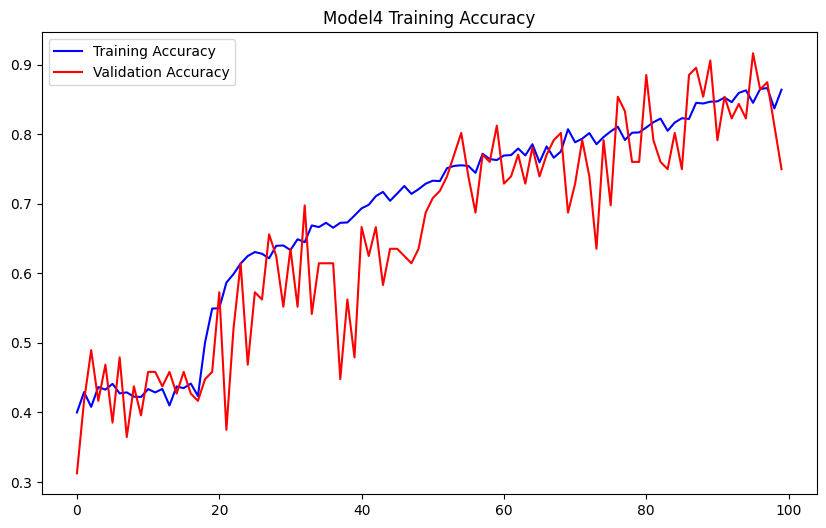

In [142]:
# Model 4 Training Accuracy

plt.figure(figsize=(10,6))
plt.title("Model4 Training Accuracy")
plt.plot(model_config4_training_info["accuracy"], color='b', label="Training Accuracy")
plt.plot(model_config4_training_info["val_accuracy"], color='r', label="Validation Accuracy")
plt.legend()

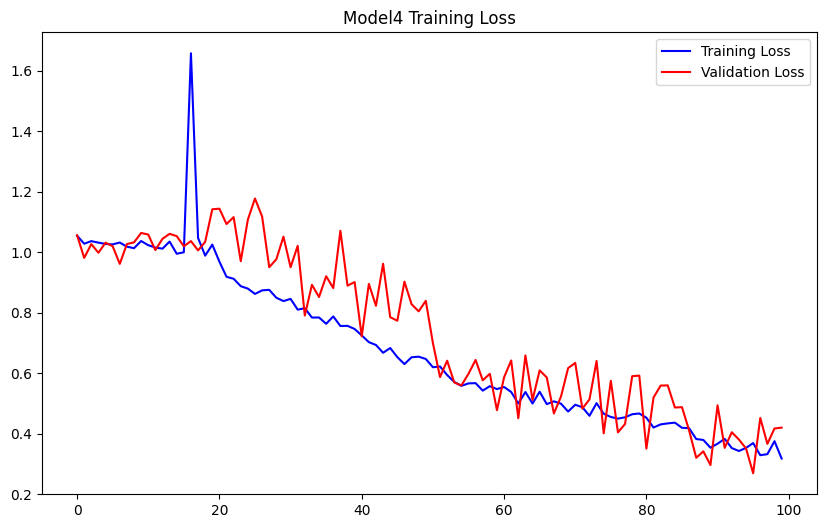

In [143]:
# Model 4 Training Loss

plt.figure(figsize=(10,6))
plt.title("Model4 Training Loss")
plt.plot(model_config4_training_info["loss"], color='b', label="Training Loss")
plt.plot(model_config4_training_info["val_loss"], color='r', label="Validation Loss")
plt.legend()

Text(0, 0.5, 'Loss')

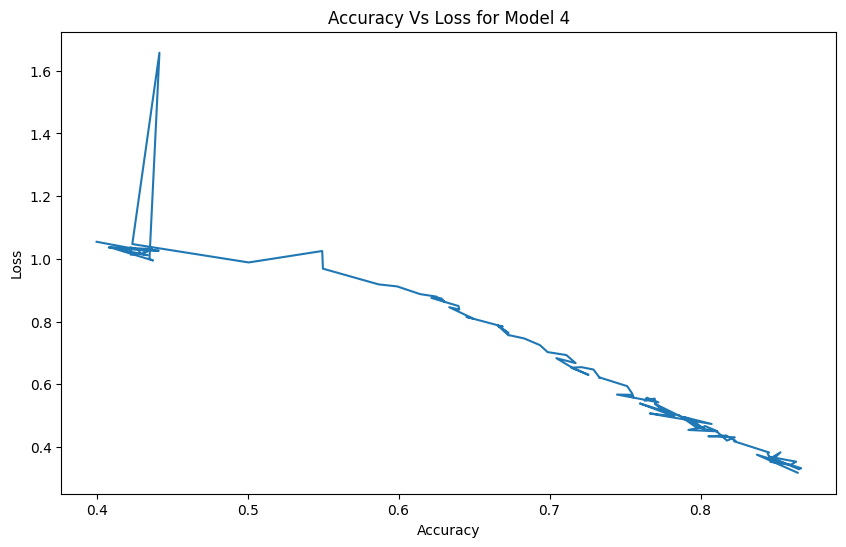

In [144]:
# Loss Vs Accuracy

x_ticks = np.linspace(np.min(model_config4_training_info.loss) - 0.001,
                      np.max(model_config4_training_info.loss) + 0.001,
                      num=N_EPOCHS)

y_ticks = np.linspace(np.min(model_config4_training_info.accuracy) - 0.001,
                      np.max(model_config4_training_info.accuracy) + 0.001,
                      num=N_EPOCHS)

plt.figure(figsize=(10, 6))
plt.plot(model_config4_training_info.accuracy, model_config4_training_info.loss)
plt.x_ticks = x_ticks
plt.y_ticks = y_ticks
plt.title('Accuracy Vs Loss for Model 4')
plt.xlabel('Accuracy')
plt.ylabel('Loss')

# Loading Saved Models from Disk

In [178]:
#model1 = load_model(model_path + '/model1_glaucoma_config1_adam_256.h5')
#model2 = load_model(model_path + '/model2_glaucoma_config2_RMSprop_256.h5')

#model3 = load_model(model_path + '/model3_lung_cancer_config3_Adam_128.h5')
model4 = load_model(model_path + '/model4_lung_cancer_config4_Adam_64.h5')


# Models Predictions and Evaluations

## Some Utility Functions

In [180]:
def load_image(img_path, target_size=(256,256), show=False):
  img = image.load_img(img_path, target_size=target_size, color_mode='rgb')

  #(height,width,channels)
  img_tensor = image.img_to_array(img)

  #img_tensor = np.vstack([img_tensor])

  #(1,height,width,channels), adds a dim coz model expects shape: (batch_size,height,width,channels)
  img_tensor = np.expand_dims(img_tensor,axis=0)

  #imshow expects values in range[0,1]
  img_tensor = img_tensor / 255.

  if show:
    plt.imshow(img_tensor[0])
    plt.axis('off')
    plt.show()

  return img_tensor


def get_class_value(x):
  if type(x) == list:
    classes = []
    for label in x:
      label_name = list(training_set_aug_images_conf4.class_indices.keys())[label]
      classes.append(label_name)

    return classes

  else:
      return list(training_set_aug_images_conf4.class_indices.keys())[x]


def get_labels(paths):
  labels = []
  for path in paths:
    label_class = path.split("/")[-2]
    label_num = training_set_aug_images.class_indices[label_class]
    labels.append(label_num)

  return labels


In [181]:
def predict(model, data, target_size=(256,256), kind='augumented', limit=0, show=False):
  """
  Predicts the class(es) of image(s) in 'data' using 'model' and returns a dictionary object.
  Arguments:
  ----------
  model (cnn model): model predict with
  data (str or augmented_image_obj): A file path or an augmented image object:
  kind (str):  Specifies the type of 'data' passed.
  limit(int): The number of images to predict from given list of paths (< size of data)
  show (bool): Determines whether the Images should be shown (will always show if kind='single')
    Value:
      * Can be any of {'augumented' / 'single' / 'multiple'}, defaults to 'augumented'.
      * Set to 'single' if data is an image path,
      * set to 'multiple' if data is a list of images paths

  """

  # Initialize predictions
  predictions = {'pred_labels':[],  'true_labels':[], 'pred_values':[],'true_values':[]}

  if kind == 'augumented':
    predictions = predict_from_aug_obj(model, data, target_size, limit, show=show)
  elif kind == 'single':
    predictions = predict_single(model, data, target_size)
  elif kind == 'multiple':
    predictions = predict_multiple(model, data, target_size, limit, show=show)

  return predictions


def predict_from_aug_obj(model, aug_img_set_obj, target_size=(256,256), limit=0, show=False):
  # result template
  #result = {'pred_labels':[], 'True_labels':true_lbls, 'pred_values':pred_vals, 'True_values':true_vals}
  pred_lbls = []
  pred_vals = []
  true_lbls = []
  true_vals = []

  if limit <= 0 or limit > len(aug_img_set_obj.filepaths):
    file_paths = aug_img_set_obj.filepaths
  else:
    file_paths = aug_img_set_obj.filepaths[:limit]

  if show:
    rows = len(file_paths) // 4
    if len(file_paths) % 4 != 0:
      rows += 1

    plt.figure(num=len(file_paths), figsize=(20, 4 * rows))

  for i,img_path in enumerate(file_paths):
    # Converting the Image to array and predict
    new_image = load_image(img_path, target_size=target_size)
    predicted = np.argmax(model.predict(new_image),axis=1)

    # Showing Prediction details
    classes = [key for key in aug_img_set_obj.class_indices]
    predicted_value = classes[predicted[0]]
    actual_value = classes[aug_img_set_obj.labels[i]]

    if show:
      img_data = plt.imread(img_path)
      plt.subplot(rows, 4, i+1)
      #ax[row, col].imshow(img_data)
      plt.imshow(img_data)
      #plt.title("Pred. :{} True :{}".format(predicted[0], aug_img_set_obj.labels[i]))
      plt.axis('off')
      plt.title("Predicted : {} ({}) \nActual : {} ({})".format(predicted[0],
                                                                predicted_value,
                                                                aug_img_set_obj.labels[i],
                                                                actual_value))

    # Add predicted label to predictions
    pred_lbls.append(predicted[0])
    pred_vals.append(predicted_value)
    true_lbls.append(aug_img_set_obj.labels[i])
    true_vals.append(actual_value)

  return {'pred_labels':pred_lbls, 'true_labels':true_lbls, 'pred_values':pred_vals, 'true_values':true_vals}


def predict_multiple(model, img_paths, target_size=(256,256), limit=0, show=False):
  pred_lbls = []
  pred_vals = []

  if limit <= 0 or limit > len(img_paths):
    file_paths = img_paths
  else:
    file_paths = img_paths[:limit]

  if show:
    rows = len(file_paths) // 4
    if len(file_paths) % 4 != 0:
      rows += 1
    # Initialize plot to 20 width and (4 x rows) height (4 for each pix)
    plt.figure(num=len(file_paths), figsize=(20, 4 * rows))

  for i, path in enumerate(file_paths):
    new_image = load_image(path, target_size)
    predicted = np.argmax(model.predict(new_image),axis=1)
    pred_lbls.append(predicted[0])
    pred_vals.append(get_class_value(predicted[0]))

    if show:
      # Show Image
      img_data = plt.imread(path)
      plt.subplot(rows, 4, i+1)
      plt.imshow(img_data)
      #plt.title("Pred. :{} True :{}".format(predicted[0], aug_img_set_obj.labels[i]))
      plt.axis('off')
      plt.title(f'Predicted: {predicted[0]} ({get_class_value(predicted[0])})')

  return {'pred_labels':pred_lbls, 'true_labels':[], 'pred_values':pred_vals, 'true_values':[]}


def predict_single(model, img_path, target_size=(256,256)):
  new_image = load_image(img_path, target_size)
  predicted = np.argmax(model.predict(new_image),axis=1)
  class_val = get_class_value(predicted[0])

  # Show Image
  img_data = plt.imread(img_path)
  plt.imshow(img_data)
  plt.title(f'Pred.: {predicted[0]} ({class_val})')
  plt.axis('off')

  return {'pred_labels':[predicted[0]], 'true_labels':[], 'pred_values':[class_val], 'true_values':[]}

def predict_multiple_v2(model, data, target_size=(256,256), limit=0):
  pred_labels = []
  pred_values = []

  if limit <= 0 or limit > len(data):
    file_paths = data
  else:
    file_paths = data[:limit]

  for path in file_paths:
    result = predict_single(model, path, target_size)
    pred_labels.append(result["pred_labels"][0])
    pred_values.append([result["pred_values"][0]])

  return {'pred_labels':pred_labels, 'true_labels':[], 'pred_values':pred_values, 'true_values':[]}


# Evaluating the Trained Models Prediction with the Test Set

## Testset Data for Model 1 and Model 2, Model 3 and Model 4

In [182]:
# Loading Testing Set data for Model 1 and Model 2

print(f'\nClass Indices: \n{testing_set_aug_images.class_indices}\n')
print(f'True Labels: \n{testing_set_aug_images.labels}')

True_labels = testing_set_aug_images.labels
#test_set_paths = testing_set_aug_images.filenames
#test_set_paths = testing_set_aug_images.filepaths


Class Indices: 
{'Bengin_cases': 0, 'Malignant_cases': 1, 'Normal_cases': 2}

True Labels: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [183]:
#scores1 = model1.evaluate_generator(generator=testing_set_aug_images, steps=int(0.75 * len(testing_set_aug_images.labels) / BATCH_SIZE), verbose=2)
#scores2 = model2.evaluate_generator(generator=testing_set_aug_images, steps=int(0.75 * len(testing_set_aug_images.labels) / BATCH_SIZE), verbose=2)

#scores3 = model3.evaluate_generator(generator=testing_set_aug_images_conf3, steps=int(0.75 * len(testing_set_aug_images_conf3.labels) / BATCH_SIZE), verbose=2)
scores4 = model4.evaluate_generator(generator=testing_set_aug_images_conf4, steps=int(0.75 * len(testing_set_aug_images_conf4.labels) / BATCH_SIZE), verbose=2)


C:\Users\USER\AppData\Local\Temp\ipykernel_11272\490500975.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores4 = model4.evaluate_generator(generator=testing_set_aug_images_conf4, steps=int(0.75 * len(testing_set_aug_images_conf4.labels) / BATCH_SIZE), verbose=2)


9/9 - 7s - loss: 0.2549 - accuracy: 0.9097 - 7s/epoch - 769ms/step


# Predictions Made from the Test Set

In [184]:
#pred_test_model1 = predict(model=model1, data=testing_set_aug_images, target_size=(256,256), kind='augumented', limit=0, show=False)
#pred_test_model2 = predict(model=model2, data=testing_set_aug_images, target_size=(256,256), kind='augumented', limit=0, show=False)

#pred_test_model3 = predict(model=model3, data=testing_set_aug_images_conf3, target_size=(128,128), kind='augumented', limit=0, show=False)
pred_test_model4 = predict(model=model4, data=testing_set_aug_images_conf4, target_size=(64,64), kind='augumented', limit=0, show=False)


1/1 [==============================] - 0s 55ms/step


## True Labels

In [185]:
# True Labels

y_true_test = testing_set_aug_images.labels.tolist()
y_true_test3 = testing_set_aug_images_conf3.labels.tolist()
y_true_test4 = testing_set_aug_images_conf4.labels.tolist()

## Model 1 Predictions

In [ ]:
# Top 15 Predictions made by Model 1

y_pred_test_model1 = pd.DataFrame(pred_test_model1)
y_pred_test_model1.head(15)

## Model 2 Predictions

In [ ]:
# Top 15 Predictions made by Model 2

y_pred_test_model2 = pd.DataFrame(pred_test_model2)
y_pred_test_model2.head(15)

## Model 3 Predictions

In [ ]:
# Top 15 Predictions made by Model 3

y_pred_test_model3 = pd.DataFrame(pred_test_model3)
y_pred_test_model3.head(50)

## Model 4 Predictions

In [190]:
# Top 15 Predictions made by Model 4

y_pred_test_model4 = pd.DataFrame(pred_test_model4)
y_pred_test_model4.tail(200)

,pred_labels,true_labels,pred_values,true_values
196,1,1,Malignant_cases,Malignant_cases
197,1,1,Malignant_cases,Malignant_cases
198,1,1,Malignant_cases,Malignant_cases
199,1,1,Malignant_cases,Malignant_cases
200,1,1,Malignant_cases,Malignant_cases
...,...,...,...,...
391,2,2,Normal_cases,Normal_cases
392,2,2,Normal_cases,Normal_cases
393,2,2,Normal_cases,Normal_cases
394,2,2,Normal_cases,Normal_cases


# Performance Evaluation of Each Model Performances

## Model 1 Performances

In [ ]:
# Classification Report

print("\n")
print("\t\tClassification Report for Model 1")
print("\t\t----------------------------------\n")

print(classification_report(y_true_test, y_pred_test_model1.pred_labels))


In [ ]:
# Confusion Matrix

conf_mat = confusion_matrix(y_true_test, y_pred_test_model1.pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Model 1")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


In [ ]:
print("Evaluation Metrics (Model 1)")
print('----------------------------\n')
print('Accuracy: \t', np.round(accuracy_score(y_true_test, y_pred_test_model1.pred_labels), 3))
print('Recall: \t', np.round(recall_score(y_true_test, y_pred_test_model1.pred_labels, average="weighted"), 3))
print('Precision: \t', np.round(precision_score(y_true_test, y_pred_test_model1.pred_labels, average="weighted"), 3))
print('F1-Score: \t', np.round(f1_score(y_true_test, y_pred_test_model1.pred_labels, average="weighted"), 3))
#print('ROC_AUC: \t', roc_auc_score(y_true_test, y_pred_test_model1.pred_labels, multi_class='ovo'))


## Model 2 Performances

In [ ]:
# Classification Report

print("\n")
print("\t\tClassification Report for Model 2")
print("\t\t----------------------------------\n")

print(classification_report(y_true_test, y_pred_test_model2.pred_labels))


In [ ]:
# Confusion Matrix

conf_mat = confusion_matrix(y_true_test, y_pred_test_model2.pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Model 2")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


In [ ]:
print("Evaluation Metrics (Model 2)")
print('----------------------------\n')
print('Accuracy: \t', np.round(accuracy_score(y_true_test, y_pred_test_model2.pred_labels), 3))
print('Recall: \t', np.round(recall_score(y_true_test, y_pred_test_model2.pred_labels, average="weighted"), 3))
print('Precision: \t', np.round(precision_score(y_true_test, y_pred_test_model2.pred_labels, average="weighted"), 3))
print('F1-Score: \t', np.round(f1_score(y_true_test, y_pred_test_model2.pred_labels, average="weighted"), 3))
#print('ROC_AUC: \t', roc_auc_score(y_true_test, y_pred_test_model2.pred_labels, multi_class='ovo'))


## Model 3 Performances

In [ ]:
# Classification Report

print("\n")
print("\t\tClassification Report for Model 3")
print("\t\t----------------------------------\n")

print(classification_report(y_true_test3, y_pred_test_model3.pred_labels))


In [ ]:
# Confusion Matrix

conf_mat = confusion_matrix(y_true_test3, y_pred_test_model3.pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Model 3")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


In [ ]:
print("Evaluation Metrics (Model 3)")
print('----------------------------\n')
print('Accuracy: \t', np.round(accuracy_score(y_true_test3, y_pred_test_model3.pred_labels), 3))
print('Recall: \t', np.round(recall_score(y_true_test3, y_pred_test_model3.pred_labels, average="weighted"), 3))
print('Precision: \t', np.round(precision_score(y_true_test3, y_pred_test_model3.pred_labels, average="weighted"), 3))
print('F1-Score: \t', np.round(f1_score(y_true_test3, y_pred_test_model3.pred_labels, average="weighted"), 3))
#print('ROC_AUC: \t', roc_auc_score(y_true_test3, y_pred_test_model3.pred_labels, multi_class='ovo'))


## Model 4 Performances

In [191]:
# Classification Report

print("\n")
print("\t\tClassification Report for Model 4")
print("\t\t----------------------------------\n")

print(classification_report(y_true_test4, y_pred_test_model4.pred_labels))




		Classification Report for Model 4
		----------------------------------

              precision    recall  f1-score   support

           0       0.75      0.73      0.74        55
           1       0.98      0.98      0.98       178
           2       0.89      0.90      0.90       163

    accuracy                           0.91       396
   macro avg       0.88      0.87      0.87       396
weighted avg       0.91      0.91      0.91       396



Text(45.722222222222214, 0.5, 'True Label')

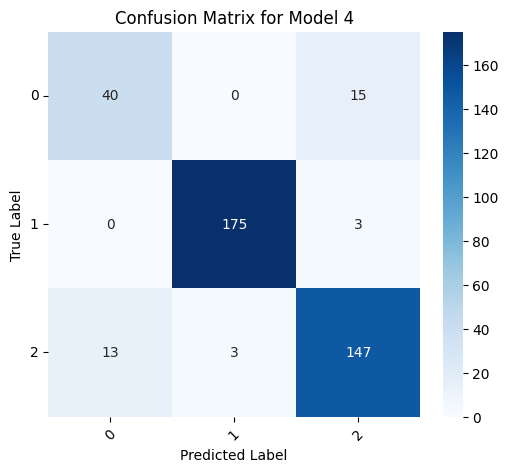

In [192]:
# Confusion Matrix

conf_mat = confusion_matrix(y_true_test4, y_pred_test_model4.pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Model 4")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")


In [193]:
print("Evaluation Metrics (Model 4)")
print('----------------------------\n')
print('Accuracy: \t', np.round(accuracy_score(y_true_test4, y_pred_test_model4.pred_labels), 3))
print('Recall: \t', np.round(recall_score(y_true_test4, y_pred_test_model4.pred_labels, average="weighted"), 3))
print('Precision: \t', np.round(precision_score(y_true_test4, y_pred_test_model4.pred_labels, average="weighted"), 3))
print('F1-Score: \t', np.round(f1_score(y_true_test4, y_pred_test_model4.pred_labels, average="weighted"), 3))
#print('ROC_AUC: \t', roc_auc_score(y_true_test4, y_pred_test_model4.pred_labels, multi_class='ovo'))


Evaluation Metrics (Model 4)
----------------------------

Accuracy: 	 0.914
Recall: 	 0.914
Precision: 	 0.913
F1-Score: 	 0.914


# Visualized Predictions

In [194]:
img_path2 = origin_path + '/test_set/Malignant_cases/'
img_path1 = origin_path + '/test_set/Bengin_cases/'
img_path3 = origin_path + '/test_set/Normal_cases/'

temp_images = [img_path1 + path for path in listdir(img_path1)]
temp_images.extend([img_path2 + path for path in listdir(img_path2)])
temp_images.extend([img_path3 + path for path in listdir(img_path3)])

print(f'Number of CT-Scan Cancer Images to test: \t {len(temp_images)}')


Number of CT-Scan Cancer Images to test: 	 396


In [195]:
# Shuffles the test set and randomly samples 30 images from there (So all categories will be represented)

np.random.shuffle(temp_images)
temp_images = list(np.random.choice(temp_images, size=10))

print(f'Number of CT-Scan Cancer Images to test: \t {len(temp_images)}')

Number of CT-Scan Cancer Images to test: 	 10


## Model 1

In [ ]:
print("\n")
print("\t\t\t\t\tMODEL 1 PREDICTIONS")
print("\t\t\t\t\t*******************\n")
pred = predict(model1, data=temp_images, target_size=(256,256), kind="multiple", limit=0, show=True)

In [ ]:
pred = predict(model1, data=testing_set_aug_images, target_size=(256,256), kind="augumented", limit=16, show=True)
pred = pd.DataFrame(pred)

print("\n\t\t\t********************************\n")
print("\t\t\t\t RESULTs")
print("\t\t\t\t -------\n")
print(f"\t\t\t Accuracy: \t {np.round(accuracy_score(pred.true_labels, pred.pred_labels), 2) * 100} %")
print(f"\t\t\t Recall: \t {np.round(recall_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\t\t\t Precision: \t {np.round(precision_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\t\t\t F1-score: \t {np.round(f1_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print("\n\t\t\t********************************")
print("\n\n")


## Model 2

In [ ]:
print("\n")
print("\t\t\t\t\tMODEL 2 PREDICTIONS")
print("\t\t\t\t\t*******************\n")
pred = predict(model2, data=temp_images, target_size=(256,256), kind="multiple", limit=0, show=True)

In [ ]:
pred = predict(model2, data=testing_set_aug_images, target_size=(256,256), kind="augumented", limit=16, show=True)
pred = pd.DataFrame(pred)

print("\n\t\t\t********************************\n")
print("\t\t\t\t RESULTs")
print("\t\t\t\t -------\n")
print(f"\t\t\t Accuracy: \t {np.round(accuracy_score(pred.true_labels, pred.pred_labels), 2) * 100} %")
print(f"\t\t\t Recall: \t {np.round(recall_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\t\t\t Precision: \t {np.round(precision_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\t\t\t F1-score: \t {np.round(f1_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print("\n\t\t\t********************************")
print("\n\n")


## Model 3

In [ ]:
print("\n")
print("\t\t\t\t\tMODEL 3 PREDICTIONS")
print("\t\t\t\t\t*******************\n")
pred = predict(model3, data=temp_images, target_size=(128,128), kind="multiple", limit=0, show=True)

In [ ]:
pred = predict(model3, data=testing_set_aug_images_conf3, target_size=(128,128), kind="augumented", limit=16, show=True)
pred = pd.DataFrame(pred)

print("\n\t\t\t********************************\n")
print("\t\t\t\t RESULTs")
print("\t\t\t\t -------\n")
print(f"\t\t\t Accuracy: \t {np.round(accuracy_score(pred.true_labels, pred.pred_labels), 2) * 100} %")
print(f"\t\t\t Recall: \t {np.round(recall_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\t\t\t Precision: \t {np.round(precision_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\t\t\t F1-score: \t {np.round(f1_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print("\n\t\t\t********************************")
print("\n\n")


## Model 4



					MODEL 4 PREDICTIONS
					*******************

1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 55ms/step


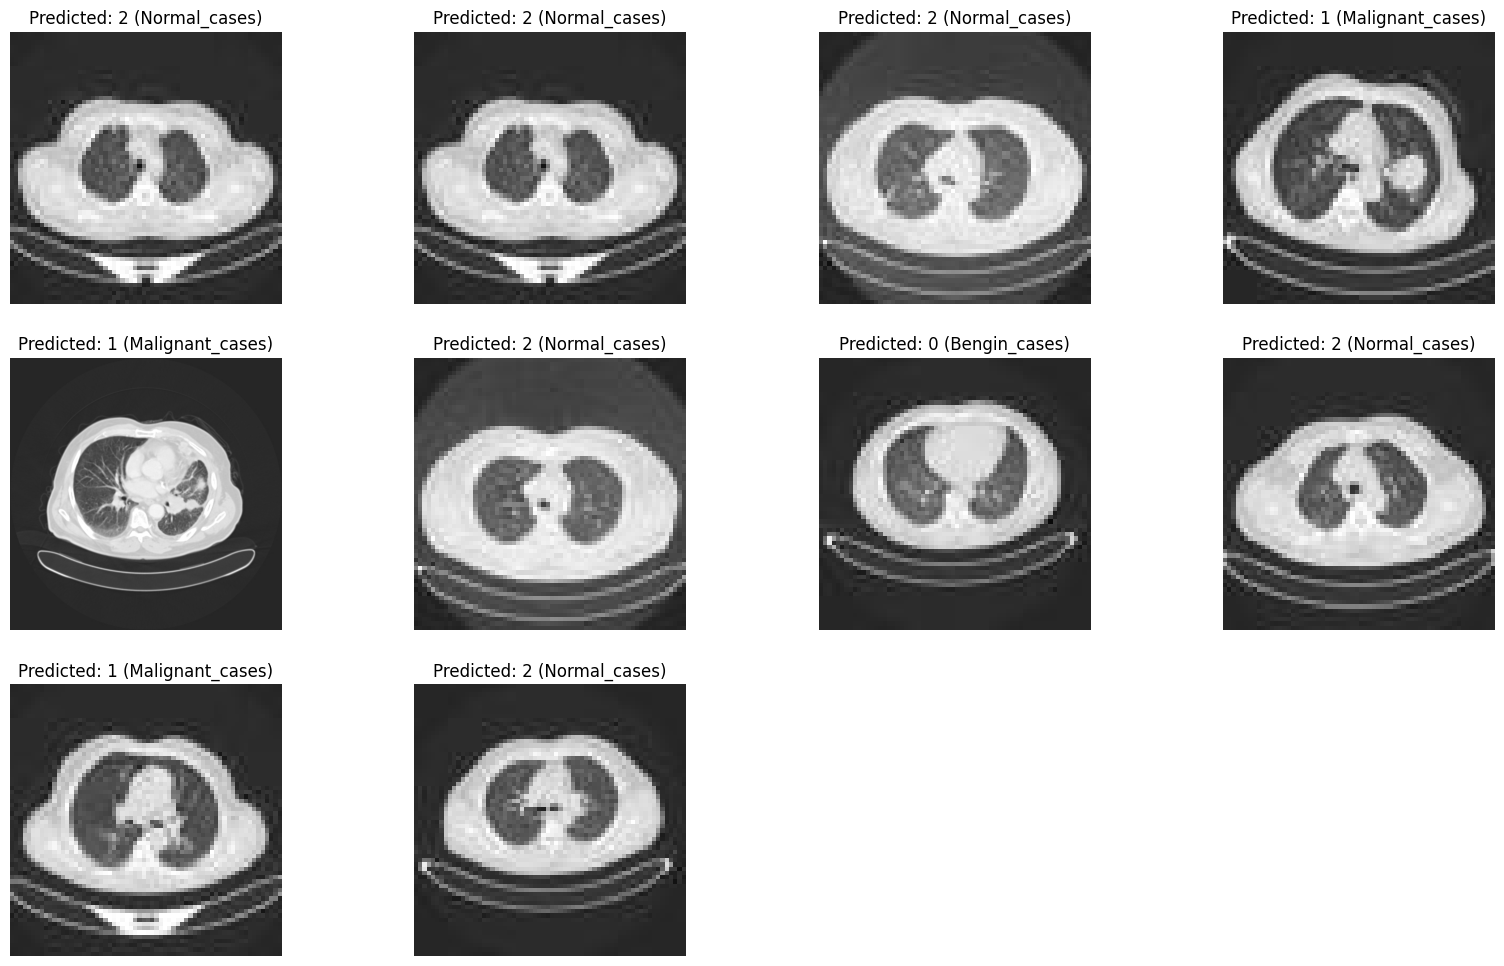

In [196]:
print("\n")
print("\t\t\t\t\tMODEL 4 PREDICTIONS")
print("\t\t\t\t\t*******************\n")
pred = predict(model4, data=temp_images, target_size=(64,64), kind="multiple", limit=0, show=True)

1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 65ms/step

			********************************

				 RESULTs
				 -------

			 Accuracy: 	 75.0 %
			 Recall: 	 75.0 %
			 Precision: 	 100.0 %
			 F1-score: 	 86.0 %

			********************************





C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


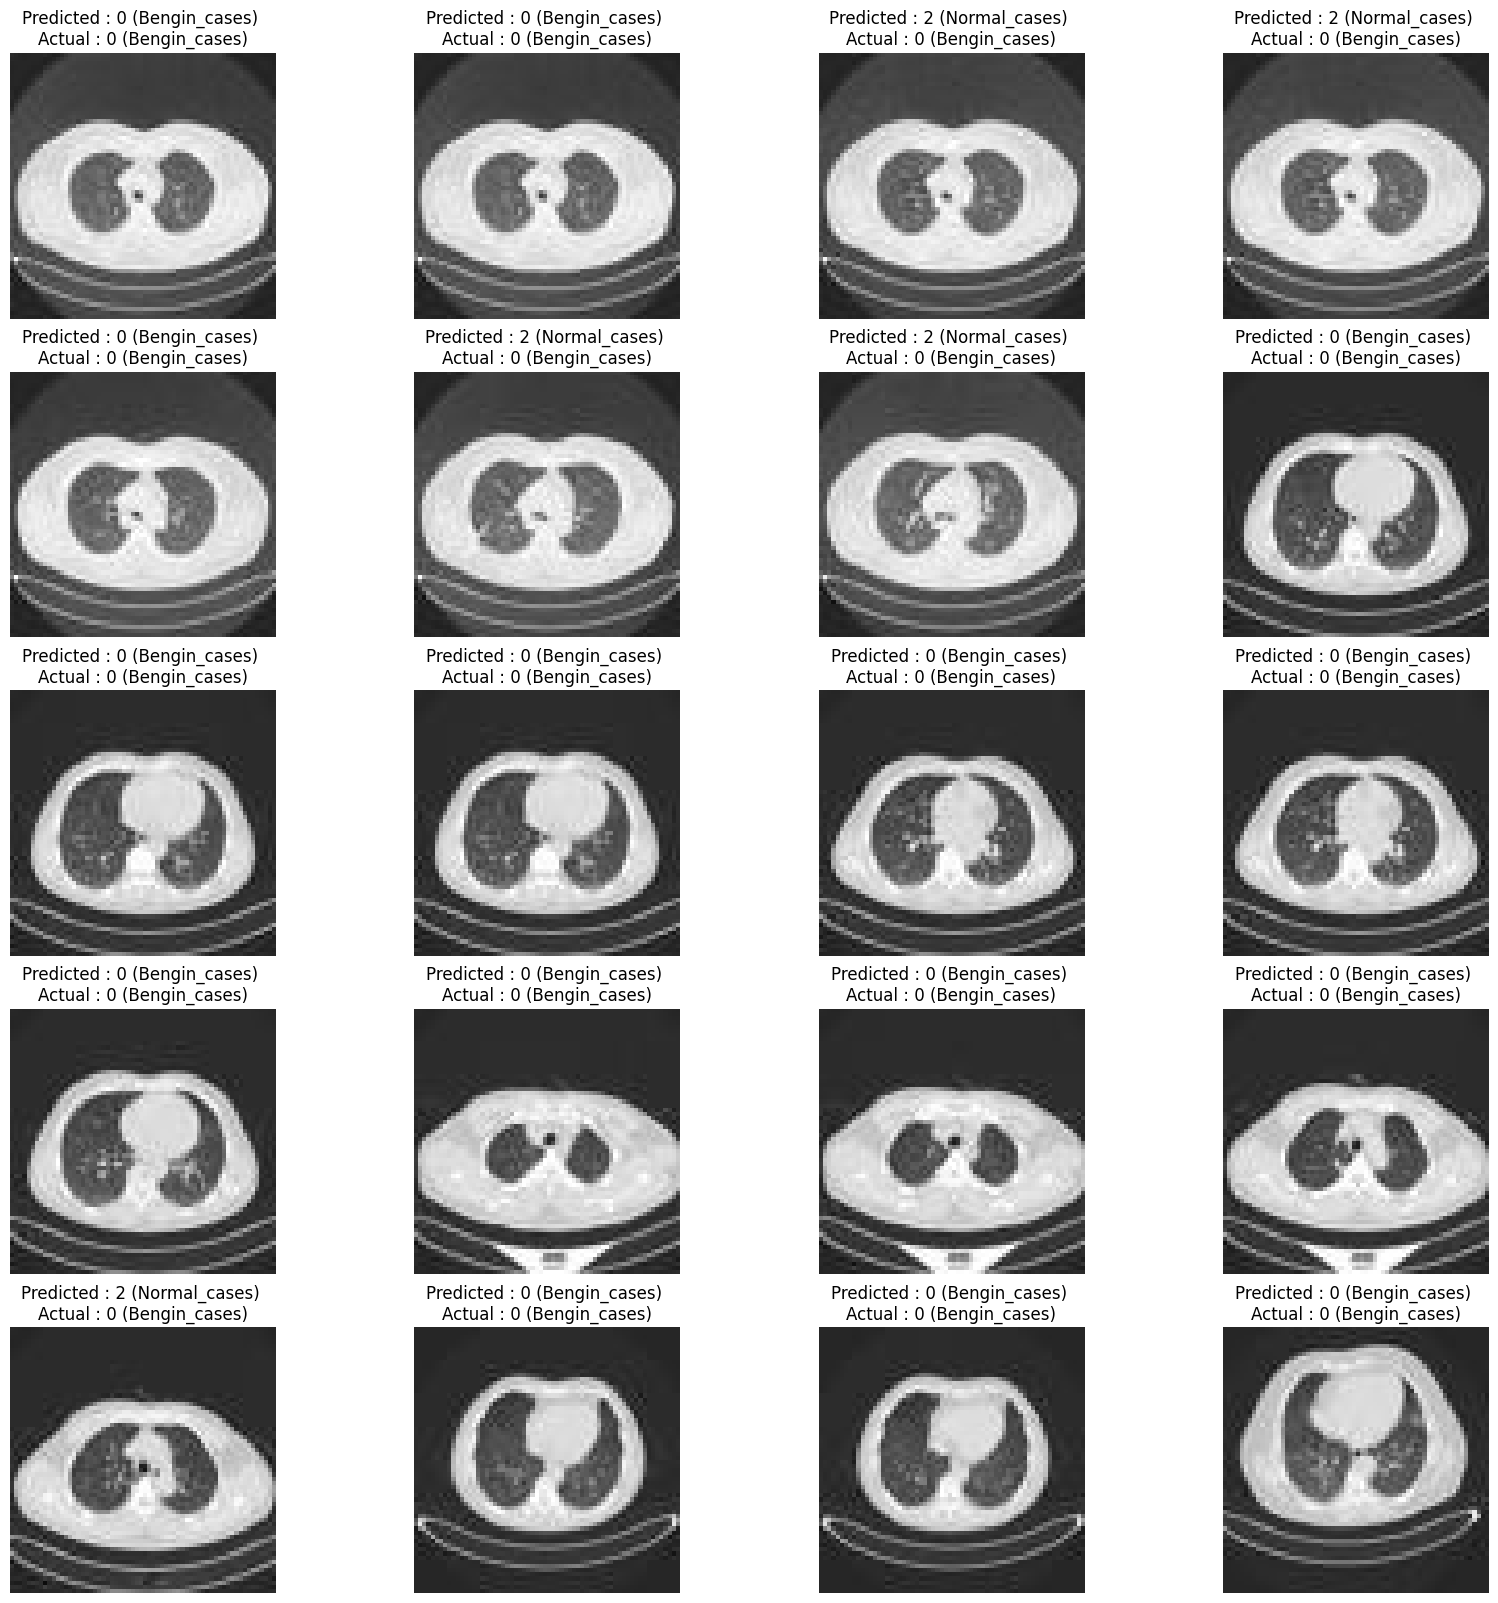

In [197]:
pred = predict(model4, data=testing_set_aug_images_conf4, target_size=(64,64), kind="augumented", limit=20, show=True)
pred = pd.DataFrame(pred)

print("\n\t\t\t********************************\n")
print("\t\t\t\t RESULTs")
print("\t\t\t\t -------\n")
print(f"\t\t\t Accuracy: \t {np.round(accuracy_score(pred.true_labels, pred.pred_labels), 2) * 100} %")
print(f"\t\t\t Recall: \t {np.round(recall_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\t\t\t Precision: \t {np.round(precision_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print(f"\t\t\t F1-score: \t {np.round(f1_score(pred.true_labels, pred.pred_labels, average='weighted'), 2) * 100} %")
print("\n\t\t\t********************************")
print("\n\n")


# ================= THE END ====================